In [2]:
# https://docs.python.org/3/library/sys.html
import sys
# https://docs.python.org/3/library/hashlib.html#hash-algorithms
import hashlib
# https://pymultihash.readthedocs.io/en/latest/#
import multihash
# https://py-multicodec.readthedocs.io/en/stable/
from multicodec import add_prefix, remove_prefix, get_codec
# https://github.com/multiformats/py-multibase
import multibase
# https://github.com/parrt/lolviz
from lolviz import *
# https://github.com/parrt/lolviz#preferencess
prefs.max_str_len = 64
# https://github.com/parrt/lolviz/blob/master/examples.ipynb
from IPython.display import display
# https://bitstring.readthedocs.io/en/latest/index.html
from bitstring import Bits, BitArray, BitStream, ConstBitStream
# https://github.com/ilanschnell/bitarray
from bitarray import bitarray
from bitarray.util import int2ba, ba2int, strip
# https://github.com/multiformats/unsigned-varint
import varint
# https://github.com/tqdm/tqdm
from tqdm import tqdm

In [3]:
# минимально необходимая длина для переданного целого
def bitLen(intValue):
    # работаем только с положительными целыми числами
    if intValue < 0:
        raise Exception("Only unsigned integers allowed")
    # для представления нуля все равно нужен 1 бит
    if intValue == 0:
        return 1
    length = 0
    while (intValue):
        intValue >>= 1
        length += 1
    return(length)

for i in range(17):
     print(i, ':', bitLen(i))

0 : 1
1 : 1
2 : 2
3 : 2
4 : 3
5 : 3
6 : 3
7 : 3
8 : 4
9 : 4
10 : 4
11 : 4
12 : 4
13 : 4
14 : 4
15 : 4
16 : 5


In [4]:
# привести двоичное значение к каноническому виду - убрать ведущие нули, сократить длину до минимально необходимой
def normalizeBinaryValue(value):
    intValue    = value.uint
    minLength   = bitLen(intValue) # len(int2ba(intValue, signed=False))
    newFormat = "uint:" + str(minLength) + "=" + str(intValue)
    return Bits(newFormat)

testNotNormalizedValue = Bits('0x111111')
print("Before normalization:", testNotNormalizedValue.bin, "|", len(testNotNormalizedValue))
testNormalizedValue = normalizeBinaryValue(testNotNormalizedValue)
print("After normalization:", testNormalizedValue.bin, "|", len(testNormalizedValue))

Before normalization: 000100010001000100010001 | 24
After normalization: 100010001000100010001 | 21


In [5]:
# compute hash block bytes or load it from menory
def getHashBlock(nounce, type="sha512"):
    nounceHash = hashlib.sha512(varint.encode(nounce)).digest()
    return Bits(bytes=nounceHash)

print(getHashBlock(1), len(getHashBlock(1)))
print(getHashBlock(2), len(getHashBlock(2)))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339 512
0xfab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f69dcca 512


In [6]:
# вычислить два соседних блока хешей - чтобы можно было искать значения которые находятся на стыке блоков
def getExtendedHashBlock(nounce, type="sha512"):
    currentBlock = getHashBlock(nounce, type)
    nextBlock    = getHashBlock(nounce + 1, type)
    # prevBlock    = getHashBlock(nounce - 1, type)
    return (currentBlock + nextBlock)
print(getExtendedHashBlock(1), len(getExtendedHashBlock(1)))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab848c9b657a853ee37c09cbfdd149d0b3807b191dde9b623ccd95281dd18705b48c89b1503903845bba5753945351fe6b454852760f73529cf01ca8f... 1024


In [7]:
# получить часть пространства хешей двух соседних блоков в котором может находится указанное значение
def getSearchHashBlock(nounce, value):
    valueLength  = len(value)
    blockLength  = 512
    hashBlock = getExtendedHashBlock(nounce)
    # получаем длину пространства хешей двух смежных блоков в котором может располагаться значение
    searchLength = blockLength + valueLength - 1
    return hashBlock[0:searchLength]

In [8]:
# найти значение битовой последовательности внутри блока
def findValueInBlock(nounce, value, count=1, normalize=False, bytealigned=False, start=0):
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # добавляем несколько бит из соседнего блока чтобы можно было искать значения на стыке блоков
    hashBlock = getSearchHashBlock(nounce, value)
    return list(hashBlock.findall(value, start=start, count=count, bytealigned=bytealigned))

testSearchHashBlock = getSearchHashBlock(1, Bits('0x39fa'))
print(testSearchHashBlock, len(testSearchHashBlock))
testFindValueInBlock = findValueInBlock(1, Bits('0x39fa'))
print(testFindValueInBlock)
print(Bits('0x39fa').bin, len(Bits('0x39fa')))

0x7b54b66836c1fbdd13d2441d9e1434dc62ca677fb68f5fe66a464baadecdbd00576f8d6b5ac3bcc80844b7d50b1cc6603444bbe7cfcf8fc0aa1ee3c636d9e339fab, 0b100 527
[504]
0011100111111010 16


In [9]:
# получить значение из блока хешей
def readValueFromBlock(nounce, start, length):
    end = start + length
    hashBlock = getExtendedHashBlock(nounce)
    return hashBlock[start:end]

testValueStartsBlock1EndsBlock2 = Bits('0x39fa') 
print(testValueStartsBlock1EndsBlock2)
print(readValueFromBlock(1, 504, 16))

0x39fa
0x39fa


In [292]:
# найти значение в пространстве хешей, в рамках указанного диапазона блоков
# эта функция возвращает все позиции бит в блоке, с которых начинается переданное значение
def findValueInHashes(value, fromNounce, toNounce, normalize=False, bytealigned=False):
    # сохраняем переданное значение и его длину до нормализации
    inputValue       = Bits(value)
    inputValueLength = len(inputValue)
    # нормализуем переданное значение, убирая лишние нули в старших битах
    if (normalize == True):
        value = normalizeBinaryValue(value)
    # вычисляем длину найденного значения чтобы корректно вычислить координаты для чтения
    valueLength = len(value)
    # размер одного блока хеша в битах
    blockSize     = 512
    # количество просмотренных блоков
    blocksProcessed = 0
    for nounce in tqdm(range(fromNounce, toNounce)):
        # ищем значение в блоке
        startPositions  = findValueInBlock(nounce, value, normalize=normalize, bytealigned=bytealigned)
        blocksProcessed = blocksProcessed + 1
        # возвращаем координаты значения если оно присутствует в блоке
        if (len(startPositions) > 0):
            # абсолютное смещение внутри пространства хещей от первого блока (в битах)
            offset = blockSize * nounce
            # номер первого бита значения внутри блока
            start  = startPositions[0]
            # номер последнего бита значения внутри блока
            end    = start + valueLength
            # абсолютный адрес начала и конца последовательности в битах, начиная от 0
            absoluteStart = offset + start
            absoluteEnd   = offset + end
            return {
                "success": True,
                "nounce":  nounce,
                "start":   start,
                "end":     end,
                "length":  valueLength,
                "meta": {
                    "value":            value,
                    "valueLength":      valueLength,
                    # "inputValue":       inputValue,
                    # "inputValueLength": inputValueLength,
                    "absoluteStart":    absoluteStart,
                    "absoluteEnd":      absoluteEnd,
                    "offset":           offset,
                    "fromNounce":       fromNounce,
                    "toNounce":         toNounce,
                    "blocksProcessed":  blocksProcessed,
                    "allPositions":     startPositions,
                    "valuesFound":      len(startPositions),
                }
            }
    return {
        "success": False,
        "meta": {
            "value":            value,
            "valueLength":      valueLength,
            # "inputValue":       inputValue,
            # "inputValueLength": inputValueLength,
            "fromNounce":       fromNounce,
            "toNounce":         toNounce,
            "blocksProcessed":  blocksProcessed,
            "valuesFound":      0,
        }
    }

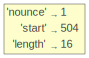

In [11]:
# создать указатель на найденное значение
def createPointerToValue(valueData):
    if (valueData["success"] == False):
        raise Exception("Pointer cannot be created: value not found")
    return {
        "nounce": valueData["nounce"],
        "start":  valueData["start"],
        "length": valueData["length"],
    }

testValueInHashes = findValueInHashes(Bits('0x39fa'), 1, 2**16)
testCreatePointerToValue = createPointerToValue(testValueInHashes)
display(objviz(testCreatePointerToValue))

In [12]:
def parseBitPosition(bitPosition):
    """
    Get hash block nounce, and byte-aligned position from absolute bit position
    """
    bytePosition = bitPosition // 8
    nounce       = bitPosition // 512
    blockBit     = bitPosition % 512
    blockByte    = blockBit // 8
    return {
        "bit": bitPosition,
        "byte": bytePosition,
        "start": blockBit,
        "blockBit": blockBit,
        "blockByte": blockByte,
        "nounce": nounce
    }

def parseBytePosition(bytePosition):
    """
    Get hash block nounce, and byte-aligned position from absolute byte position
    """
    bitPosition = bytePosition * 8
    return parseBitPosition(bitPosition)

testParseBitPosition1 = parseBitPosition(535)
print(testParseBitPosition1)
testParseBitPosition1 = parseBitPosition(5002481)
print(testParseBitPosition1)
testParseBytePosition = parseBytePosition(66)
print(testParseBytePosition)

{'bit': 535, 'byte': 66, 'start': 23, 'blockBit': 23, 'blockByte': 2, 'nounce': 1}
{'bit': 5002481, 'byte': 625310, 'start': 241, 'blockBit': 241, 'blockByte': 30, 'nounce': 9770}
{'bit': 528, 'byte': 66, 'start': 16, 'blockBit': 16, 'blockByte': 2, 'nounce': 1}


In [13]:
def readBitPosition(bitPosition, length):
    """
    Read bits from hash space
    """
    cursor = parseBitPosition(bitPosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], length)

testBitPositionValue = Bits('0xde')
testAbsoluteBitPosition = findValueInHashes(testBitPositionValue, 0, 512)["meta"]["absoluteStart"]
testCursorPosition  = parseBitPosition(testAbsoluteBitPosition)
testReadBitPosition = readBitPosition(70, 8)

print('Value:', testBitPositionValue)
print('Cursor position:', testCursorPosition)
print('Bit position:', testAbsoluteBitPosition)
print('result:', testReadBitPosition)

Value: 0xde
Cursor position: {'bit': 70, 'byte': 8, 'start': 70, 'blockBit': 70, 'blockByte': 8, 'nounce': 0}
Bit position: 70
result: 0xde


In [14]:
def readBytePosition(bytePosition):
    """
    Read one byte from hash space
    """
    cursor = parseBytePosition(bytePosition)
    return readValueFromBlock(cursor["nounce"], cursor["blockBit"], 8)

testBytePositionValue = Bits('0xde')
testCursorPosition    = createPointerToValue(findValueInHashes(testBytePositionValue, 0, 512))
testReadBytePosition  = readBitPosition(42, 8)

print('Value:', testBytePositionValue)
print('Cursor position:', testCursorPosition)
print('Byte position:', testReadBytePosition)

Value: 0xde
Cursor position: {'nounce': 0, 'start': 70, 'length': 8}
Byte position: 0x07


In [15]:
def findByteLocations(dataBytes):
    # distance to previous value in bytes
    prevAddress = None
    nextAddress = None
    prevPointer = None
    nextPointer = None
    # last located value
    prevValue   = None
    nextValue   = None
    # start hash block number (nounce)
    fromNounce  = 0
    # max distance to next value (in bytes)
    maxByteDistance = 2 ** 16
    # max distance in 512-bit hash blocks
    maxBlockDistance = ((maxByteDistance * 8) // 512)
    # last saved value position
    prevLocation = 0
    # all value locations in orer apperance
    locations = list()
    for currentByte in dataBytes:
        # prepare byte for search
        currentBits = Bits(uint=currentByte, length=8)
        # searching from left to right, one direction
        if (prevLocation):
            # TODO disable "+1" shift
            fromNounce = prevLocation["nounce"] + 1
        # calculate available search range
        toNounce = fromNounce + maxBlockDistance
        # searching byte location
        location = findValueInHashes(currentBits, fromNounce, toNounce, bytealigned=True)
        # print('Location:', location)
        location["address"]     = parseBitPosition(location["meta"]["absoluteStart"])
        location["prevAddress"] = None
        location["nextAddress"] = None
        # value not found
        if (location["success"] == False):
            raise ValueError("byte value not found after 128 blocks")
        # send last location to result array
        if (prevLocation):
            # calculate relative distance between values
            relativeDistance = (location["address"]["byte"] - prevLocation["address"]["byte"])
            # save distance to result
            location["prevAddress"]      = relativeDistance
            # address = prev position - current position
            prevLocation["nextAddress"]  = relativeDistance
            # prevLocation["nextLocation"] = location
        # save results
        locations.append(location)
        # save last value location tbefore going to next byte
        prevLocation = location
    return locations

testFindByteLocations = findByteLocations(Bits('0xdeadbeef').tobytes())
# display(objviz(testFindByteLocations))
for i in range(0, len(testFindByteLocations)):
    bytePointer = createPointerToValue(testFindByteLocations[i])
    print(i, ':', bytePointer, '->', readValueFromBlock(bytePointer["nounce"], bytePointer["start"], bytePointer["length"]))

0 : {'nounce': 0, 'start': 336, 'length': 8} -> 0xde
1 : {'nounce': 4, 'start': 312, 'length': 8} -> 0xad
2 : {'nounce': 6, 'start': 104, 'length': 8} -> 0xbe
3 : {'nounce': 9, 'start': 96, 'length': 8} -> 0xef


In [16]:
def updateCursor(cursor, nextItem):
    nextPosition = nextItem["address"].uint
    # print('nextPosition', nextItem["address"].uint)
    # print('nextPosition', nextItem["address"].hex)
    currentByte  = cursor["byte"]
    nextByte     = cursor["byte"] + nextPosition
    nextCursor   = parseBytePosition(nextByte)
    return nextCursor

In [17]:
xorData = Bits('0x010203f405220000670809aaff06a1aa')
locations = findByteLocations(xorData.tobytes())

In [18]:
distances = list()
for i in range(len(locations)-1, -1, -1):
    # nextLocation = locations[i+1]
    distances.append(locations[i]["nextAddress"])
    print(i, ':', locations[i]["meta"]["value"], 'd:', locations[i]["nextAddress"])
print(distances)

15 : 0xaa d: None
14 : 0xa1 d: 714
13 : 0x06 d: 259
12 : 0xff d: 163
11 : 0xaa d: 96
10 : 0x09 d: 86
9 : 0x08 d: 232
8 : 0x67 d: 513
7 : 0x00 d: 157
6 : 0x00 d: 65
5 : 0x22 d: 63
4 : 0x05 d: 1010
3 : 0xf4 d: 399
2 : 0x03 d: 103
1 : 0x02 d: 147
0 : 0x01 d: 80
[None, 714, 259, 163, 96, 86, 232, 513, 157, 65, 63, 1010, 399, 103, 147, 80]


In [20]:
print(xorData, len(xorData))
nounce = 0
hexItems = list()
currentBitPosition = 0
prevBitPosition    = 0
for i in range(0, 32):
    start     = 4 * i
    end       = start + 4
    value     = xorData[start:end]        
    location  = findValueInHashes(value, nounce, 2, normalize=False, bytealigned=False)
    distance  = location["meta"]["absoluteStart"] - prevBitPosition
    listItem  = value + Bits(uint=distance, length=8)
    hexItems.append(value)
    print(i, ':', value, location["meta"]["absoluteStart"], 'p:', currentBitPosition, 'd:', distance, 'item:', listItem)
    nounce = location["nounce"]
    currentBitPosition = currentBitPosition + distance
    prevBitPosition = currentBitPosition

0x010203f405220000670809aaff06a1aa 128
0 : 0x0 5 p: 0 d: 5 item: 0x05
1 : 0x1 7 p: 5 d: 2 item: 0x12


CreationError: uint cannot be initialsed by a negative number.

In [22]:
xorData = Bits(bytes=b'raise CreationError("uint cannot be initialsed by a negative number.")')
print(xorData, len(xorData))
chunkSize   = 40
indexStart  = len(xorData) - chunkSize
indexEnd    = len(xorData)
#xorIndex    = xorData[indexStart:indexEnd] # Bits('0x0000000000') 
xorIndex    = Bits('0x0000000000') 
# revXorIndex = xorData[len(xorData)-indexEnd:len(xorData)-indexStart] # Bits('0x0000000000')
revXorIndex = Bits('0x0000000000') 
# xorIndex    = xorIndex ^ revXorIndex
#revXorIndex = xorIndex

print('start index :', xorIndex)
print('end index   :', revXorIndex)
print("")
for i in range(0, 14):
    pad = ': '
    if (i >= 10):
        pad = ':'
    start       = chunkSize * i
    end         = start + chunkSize
    value       = xorData[start:end]
    xorIndex    = value ^ xorIndex
    revValue    = xorData[len(xorData)-end:len(xorData)-start]
    revXorIndex = revXorIndex ^ revValues
    print(i, pad, value, xorIndex, '|', revXorIndex, revValue)

0x7261697365204372656174696f6e4572726f72282275696e742063616e6e6f7420626520696e697469616c7365642062792061206e65676174697665206e756d6265722e2229 560
start index : 0x0000000000
end index   : 0x0000000000



NameError: name 'revValues' is not defined

In [84]:
Bits('0x1427541825') ^ Bits('0x513b0f576e')

Bits('0x451c5b4f4b')

In [79]:
Bits('0x562f130a73') ^ Bits('0x6f74206265')

Bits('0x395b336816')

In [90]:
Bits('0x21683e2569') ^ Bits('0x764c72641d')

Bits('0x57244c4174')

In [23]:
zsBits = Bits('0x513b0f576e')
len(zsBits)

40

In [266]:
dataBits   = Bits('0x513b0f576e')
itemSize   = 2
dataItems  = list()
for i in range(0, len(dataBits) // itemSize):
    start     = itemSize * i
    end       = start + itemSize
    value     = dataBits[start:end]
    dataItems.append(value)
    print(i, ':', value)

0 : 0b01
1 : 0b01
2 : 0b00
3 : 0b01
4 : 0b00
5 : 0b11
6 : 0b10
7 : 0b11
8 : 0b00
9 : 0b00
10 : 0b11
11 : 0b11
12 : 0b01
13 : 0b01
14 : 0b01
15 : 0b11
16 : 0b01
17 : 0b10
18 : 0b11
19 : 0b10


In [270]:
linkedList   = list()
prevPosition = 0
position     = 0
maxDistance  = 21

for i in range(1, len(dataItems)):
    currentValue = dataItems[i]
    nextValue    = None
    prevValue    = None
    if (i > 0):
        prevValue = dataItems[i-1]
    if (i < len(dataItems)-2):
        nextValue = dataItems[i+1]
    # frequency    = currentValue.uint # Bits(uint=dataItems[i], length=4)
    print("")
    print(i, ':', currentValue, 'next:', nextValue, 'p:', position)
    # print("")
    for distance in tqdm(range(1, 2**maxDistance)):
        position        = prevPosition + distance
        distanceEncoded = varint.encode(distance)
        if ((len(distanceEncoded) > 8) and (len(distanceEncoded) <= 16)):
            fullValue = prevValue[0:2] + distanceEncoded 
        elif ((len(distanceEncoded) > 16) and (len(distanceEncoded) <= 24)):
            fullValue = prevValue[0:1] + distanceEncoded 
        else:
            fullValue = prevValue + distanceEncoded
        scanValue = readBitPosition(position, len(fullValue))
        # print(scanValue, fullValue, len(scanValue), len(fullValue))
        if (scanValue == fullValue):
            prevPosition = position
            # print('position:', position, 'v:', scanValue, 'prev:', prevValue, 'full:', fullValue, len(fullValue))
            print('[match found]:', fullValue, 'l:', len(fullValue), 'pos:', position)
            print("")
            break
        # print('position:', position, 'v:', scanValue, 'fullValue:', fullValue)
        

  0%|          | 529/2097151 [00:00<06:37, 5280.34it/s]
1 : 0b01 next: 0b00 p: 0
[match found]: 0b0100111010 pos: 58


2 : 0b00 next: 0b01 p: 58
 27%|██▋       | 569844/2097151 [07:24<19:52, 1281.27it/s]


KeyboardInterrupt: 

In [269]:
linkedList = list()
prevBitPosition = 0
maxDistance     = 16

for i in range(30, -1, -1):
    nextValue    = dataItems[i+1]
    currentValue = dataItems[i]
    frequency    = currentValue.uint # Bits(uint=dataItems[i], length=4)
    print("")
    print(i, ':', currentValue, 'next:', nextValue, 'f:', frequency)
    # print("")
    for distance in tqdm(range(1, 2**maxDistance)):
        if (frequency == 0):
            frequency = 1
        nextBitPosition = prevBitPosition + (frequency * distance)
        distanceEncoded = varint.encode(distance)
        distanceValue   = Bits(bytes=distanceEncoded)# Bits(uint=distance, length=maxDistance)
        positionValue   = readBitPosition(nextBitPosition, len(distanceValue))
        # print(i, ':', distance, '->', positionValue, 'target:', currentValue,  'abs:', nextBitPosition)
        if (positionValue == distanceValue):
            linkedList.append({
                'dataValue': currentValue,
                'positionValue': positionValue,
                'distanceValue': distanceValue,
                'distanceValueLength': len(distanceValue),
                'fullValue': currentValue + distanceValue,
                'distance': distance,
                'frequency': frequency,
                'bitPosition': nextBitPosition,
                'nextValue' : None,
            })
            prevBitPosition = nextBitPosition
            print("")
            print('[valueFound]:', currentValue, 'pos:', nextBitPosition, 'dis:', distance, 'dv:', distanceValue.bin, len(distanceValue))
            break
        if (distance == (2**maxDistance - 1)):
            print("")
            print('[ERROR]: Value not found in chosen distance')
            linkedList.append({
                'dataValue': currentValue,
                'positionValue': positionValue,
                'distanceValue': distanceValue,
                'distanceValueLength': len(distanceValue),
                'fullValue': currentValue + distanceValue,
                'distance': distance,
                'frequency': currentValue.uint,
                'bitPosition': prevBitPosition,
                # hotfix
                'nextValue' : nextValue,
            })
            prevBitPosition = nextBitPosition
            # raise Exception('Value not found in chosen distance')

IndexError: list index out of range

In [122]:
print(len(linkedList))
linkedList

22


[{'dataValue': Bits('0x4'),
  'positionValue': Bits('0x4b0856'),
  'distanceValue': Bits('0xffff03'),
  'distanceValueLength': 24,
  'fullValue': Bits('0x4ffff03'),
  'distance': 65535,
  'frequency': 4,
  'bitPosition': 0,
  'nextValue': Bits('0x6')},
 {'dataValue': Bits('0x7'),
  'positionValue': Bits('0xc307'),
  'distanceValue': Bits('0xc307'),
  'distanceValueLength': 16,
  'fullValue': Bits('0x7c307'),
  'distance': 963,
  'frequency': 7,
  'bitPosition': 268881,
  'nextValue': None},
 {'dataValue': Bits('0x1'),
  'positionValue': Bits('0xef27'),
  'distanceValue': Bits('0xef27'),
  'distanceValueLength': 16,
  'fullValue': Bits('0x1ef27'),
  'distance': 5103,
  'frequency': 1,
  'bitPosition': 273984,
  'nextValue': None},
 {'dataValue': Bits('0x6'),
  'positionValue': Bits('0x91ed05'),
  'distanceValue': Bits('0xffff03'),
  'distanceValueLength': 24,
  'fullValue': Bits('0x6ffff03'),
  'distance': 65535,
  'frequency': 6,
  'bitPosition': 273984,
  'nextValue': Bits('0x1')},
 {

In [123]:
for i in range(0, len(linkedList)):
    print(i, ':', linkedList[i]["fullValue"][0:4])

0 : 0x4
1 : 0x7
2 : 0x1
3 : 0x6
4 : 0x5
5 : 0x6
6 : 0x2
7 : 0x7
8 : 0x3
9 : 0x4
10 : 0x0
11 : 0x2
12 : 0x5
13 : 0x6
14 : 0x3
15 : 0x7
16 : 0x9
17 : 0x6
18 : 0x1
19 : 0x6
20 : 0x2
21 : 0x7


In [126]:
# startItem = linkedList[31]
# startPosition = startItem['bitPosition']
for i in range(len(linkedList)-1, -1, -1):
    currentItem = linkedList[i]
    position  = currentItem["bitPosition"]
    frequency = currentItem["frequency"]
    dataValue = currentItem["fullValue"][0:4].uint
    distance  = currentItem["fullValue"][4:maxDistance].uint
    nextPosition = distance * frequency
    if (currentItem["nextValue"]):
        nextValue = currentItem["nextValue"]
    else:
        nextValue = readBitPosition(position, maxDistance)
    print(i, ':', dataValue, distance, position, frequency, nextValue)

21 : 7 4095 2245200 7 0x2
20 : 2 61 2245200 2 0x3d57
19 : 6 4095 1851868 6 0x1
18 : 1 4095 1786333 1 0x6
17 : 6 3632 1786333 6 0xe303
16 : 9 2 1783435 9 0x023f
15 : 7 37 1783417 7 0x25d0
14 : 3 62 1783158 3 0x3e19
13 : 6 4095 1389762 6 0x5
12 : 5 4095 1062087 5 0x2
11 : 2 117 1062087 2 0x75e6
10 : 0 4095 996318 0 0x4
9 : 4 64 996318 4 0x40c5
8 : 3 4095 799457 3 0x7
7 : 7 126 799457 7 0x7ea3
6 : 2 4095 667505 2 0x6
5 : 6 16 667505 6 0x1015
4 : 5 43 667409 5 0x2b89
3 : 6 4095 273984 6 0x1
2 : 1 3826 273984 1 0xef27
1 : 7 3120 268881 7 0xc307
0 : 4 4095 0 4 0x6


In [214]:
data         = Bits(bytes=b'raise CreationError("uint cannot be initialsed by a negative number.")') # Bits('0x6f7426f7420626506265')
# block sizes
addressLength = 32
valueLength   = 8
zeroAddress   = Bits(uint=0, length=addressLength)
zeroPointer   = Bits(uint=0, length=addressLength)
# result lists
pointers     = list()
addresses    = list()
values       = list()
prevPosition = 0
# prevPointer  = Bits(uint=0, length=addressLength)
prevAddress  = zeroAddress

for value in data.cut(valueLength):
    i = len(values)
    for scanOffset in range(1, 2**16):
        bytePosition = prevPosition + scanOffset
        scanByte     = readBitPosition(bytePosition, valueLength)
        # prevPosition = bytePosition
        # print(scanByte, value, scanOffset)
        if (scanByte == value):
            address = Bits(uint=bytePosition, length=addressLength)
            addresses.append(address)
            values.append(value)
            prevPosition = bytePosition
            prevAddress  = address
            print("\n[valueFound]:", value, 'a:', address, 'pos:', bytePosition)
            break
print("")
print('data:', data, len(data), len(data) // valueLength)
print('values:')
print(values)
print('addresses:')
print(addresses)


[valueFound]: 0x72 a: 0x000000d3 pos: 211

[valueFound]: 0x61 a: 0x00000327 pos: 807

[valueFound]: 0x69 a: 0x00000505 pos: 1285

[valueFound]: 0x73 a: 0x000005b4 pos: 1460

[valueFound]: 0x65 a: 0x000005f7 pos: 1527

[valueFound]: 0x20 a: 0x0000064f pos: 1615

[valueFound]: 0x43 a: 0x00000722 pos: 1826

[valueFound]: 0x72 a: 0x00000814 pos: 2068

[valueFound]: 0x65 a: 0x0000085e pos: 2142

[valueFound]: 0x61 a: 0x000008a8 pos: 2216

[valueFound]: 0x74 a: 0x00000ad4 pos: 2772

[valueFound]: 0x69 a: 0x00000c96 pos: 3222

[valueFound]: 0x6f a: 0x00000e6d pos: 3693

[valueFound]: 0x6e a: 0x00000e9a pos: 3738

[valueFound]: 0x45 a: 0x00000f70 pos: 3952

[valueFound]: 0x72 a: 0x000010fc pos: 4348

[valueFound]: 0x72 a: 0x0000116a pos: 4458

[valueFound]: 0x6f a: 0x00001212 pos: 4626

[valueFound]: 0x72 a: 0x000013eb pos: 5099

[valueFound]: 0x28 a: 0x0000168b pos: 5771

[valueFound]: 0x22 a: 0x00001746 pos: 5958

[valueFound]: 0x75 a: 0x00001755 pos: 5973

[valueFound]: 0x69 a: 0x00001812 

In [215]:
pointers = list()
for i in range(0, len(addresses)):
    currentAddress = addresses[i]
    if (i > 0):
        prevAddress = addresses[i-1]
    else:
        prevAddress = zeroAddress
    if (i < len(addresses)-1):
        nextAddress = addresses[i+1]
    else:
        nextAddress = zeroAddress
    # create pointer for this address
    currentPointer = prevAddress ^ nextAddress
    pointers.append(currentPointer)
    print(i, ':', prevAddress, currentAddress, nextAddress, '->', currentPointer)

0 : 0x00000000 0x000000d3 0x00000327 -> 0x00000327
1 : 0x000000d3 0x00000327 0x00000505 -> 0x000005d6
2 : 0x00000327 0x00000505 0x000005b4 -> 0x00000693
3 : 0x00000505 0x000005b4 0x000005f7 -> 0x000000f2
4 : 0x000005b4 0x000005f7 0x0000064f -> 0x000003fb
5 : 0x000005f7 0x0000064f 0x00000722 -> 0x000002d5
6 : 0x0000064f 0x00000722 0x00000814 -> 0x00000e5b
7 : 0x00000722 0x00000814 0x0000085e -> 0x00000f7c
8 : 0x00000814 0x0000085e 0x000008a8 -> 0x000000bc
9 : 0x0000085e 0x000008a8 0x00000ad4 -> 0x0000028a
10 : 0x000008a8 0x00000ad4 0x00000c96 -> 0x0000043e
11 : 0x00000ad4 0x00000c96 0x00000e6d -> 0x000004b9
12 : 0x00000c96 0x00000e6d 0x00000e9a -> 0x0000020c
13 : 0x00000e6d 0x00000e9a 0x00000f70 -> 0x0000011d
14 : 0x00000e9a 0x00000f70 0x000010fc -> 0x00001e66
15 : 0x00000f70 0x000010fc 0x0000116a -> 0x00001e1a
16 : 0x000010fc 0x0000116a 0x00001212 -> 0x000002ee
17 : 0x0000116a 0x00001212 0x000013eb -> 0x00000281
18 : 0x00001212 0x000013eb 0x0000168b -> 0x00000499
19 : 0x000013eb 0x0000

In [233]:
links    = list()
prevLink = zeroPointer
for i in range(0, len(pointers)):
    currentPointer = pointers[i]
    if (i > 0):
        prevPointer = pointers[i-1]
    else:
        prevPointer = zeroPointer
    if (i < len(pointers)-1):
        nextPointer    = pointers[i+1]
    else:
        nextPointer = zeroPointer
    currentLink = prevPointer ^ nextPointer
    links.append(currentLink)
    print(i, ':', prevPointer, currentPointer, nextPointer, '->', currentLink)

0 : 0x00000000 0x00000327 0x000005d6 -> 0x000005d6
1 : 0x00000327 0x000005d6 0x00000693 -> 0x000005b4
2 : 0x000005d6 0x00000693 0x000000f2 -> 0x00000524
3 : 0x00000693 0x000000f2 0x000003fb -> 0x00000568
4 : 0x000000f2 0x000003fb 0x000002d5 -> 0x00000227
5 : 0x000003fb 0x000002d5 0x00000e5b -> 0x00000da0
6 : 0x000002d5 0x00000e5b 0x00000f7c -> 0x00000da9
7 : 0x00000e5b 0x00000f7c 0x000000bc -> 0x00000ee7
8 : 0x00000f7c 0x000000bc 0x0000028a -> 0x00000df6
9 : 0x000000bc 0x0000028a 0x0000043e -> 0x00000482
10 : 0x0000028a 0x0000043e 0x000004b9 -> 0x00000633
11 : 0x0000043e 0x000004b9 0x0000020c -> 0x00000632
12 : 0x000004b9 0x0000020c 0x0000011d -> 0x000005a4
13 : 0x0000020c 0x0000011d 0x00001e66 -> 0x00001c6a
14 : 0x0000011d 0x00001e66 0x00001e1a -> 0x00001f07
15 : 0x00001e66 0x00001e1a 0x000002ee -> 0x00001c88
16 : 0x00001e1a 0x000002ee 0x00000281 -> 0x00001c9b
17 : 0x000002ee 0x00000281 0x00000499 -> 0x00000677
18 : 0x00000281 0x00000499 0x000004ad -> 0x0000062c
19 : 0x00000499 0x0000

In [242]:
crossLinks = list()
frontLinks = list()
backLinks  = list()
for i in range(0, len(links)):
    currentAddress = addresses[i]
    if (i > 0):
        prevAddress = addresses[i-1]
    else:
        prevAddress = zeroAddress
    if (i < len(addresses)-1):
        nextAddress = addresses[i+1]
    else:
        nextAddress = zeroAddress
    currentPointer = pointers[i]
    if (i > 0):
        prevPointer = pointers[i-1]
    else:
        prevPointer = zeroPointer
    if (i < len(pointers)-1):
        nextPointer    = pointers[i+1]
    else:
        nextPointer = zeroPointer
    currentLink = links[i]
    if (i > 0):
        prevLink = links[i-1]
    else:
        prevLink = zeroPointer
    if (i < len(links)-1):
        nextLink = links[i+1]
    else:
        nextLink = zeroPointer
    crossLink = prevLink ^ nextLink
    backLink  = prevLink ^ currentLink
    frontLink = currentLink ^ nextLink
    crossLinks.append(crossLink)
    backLinks.append(backLink)
    frontLinks.append(frontLink)
crossLinks

[Bits('0x000005b4'),
 Bits('0x000000f2'),
 Bits('0x000000dc'),
 Bits('0x00000703'),
 Bits('0x000008c8'),
 Bits('0x00000f8e'),
 Bits('0x00000347'),
 Bits('0x0000005f'),
 Bits('0x00000a65'),
 Bits('0x00000bc5'),
 Bits('0x000002b0'),
 Bits('0x00000397'),
 Bits('0x00001a58'),
 Bits('0x00001aa3'),
 Bits('0x000000e2'),
 Bits('0x0000039c'),
 Bits('0x00001aff'),
 Bits('0x00001ab7'),
 Bits('0x00000330'),
 Bits('0x00000dd5'),
 Bits('0x00000b06'),
 Bits('0x00000472'),
 Bits('0x0000001e'),
 Bits('0x00000ed6'),
 Bits('0x00000fc9'),
 Bits('0x000000f6'),
 Bits('0x000001ea'),
 Bits('0x000002c1'),
 Bits('0x000003d8'),
 Bits('0x000001e6'),
 Bits('0x000006f8'),
 Bits('0x0000058f'),
 Bits('0x0000004c'),
 Bits('0x00003c47'),
 Bits('0x00003ce4'),
 Bits('0x00000072'),
 Bits('0x000001a2'),
 Bits('0x00003c52'),
 Bits('0x0000359b'),
 Bits('0x00000911'),
 Bits('0x00000335'),
 Bits('0x000000d3'),
 Bits('0x00000f19'),
 Bits('0x00000f3b'),
 Bits('0x0000028c'),
 Bits('0x00000250'),
 Bits('0x00000137'),
 Bits('0x0000

In [244]:
for i in range(0, len(pointers)):
    currentPointer   = pointers[i]
    currentAddress   = addresses[i]
    currentLink      = links[i]
    currentCrossLink = crossLinks[i]
    if (i > 0):
        prevPointer = pointers[i-1]
        prevAddress = addresses[i-1]
        prevLink    = links[i-1]
    else:
        prevPointer = zeroPointer
        prevAddress = zeroAddress
        prevLink    = zeroAddress
    nextAddress = prevAddress ^ currentPointer
    nextPointer = prevPointer ^ currentLink
    # nextLink    = currentCrossLink ^ prevLink 
    nextValue   = readBitPosition(nextAddress.uint, valueLength)
    # print(i, ':', 'ca:', currentAddress, 'cp:', currentPointer)
    print(i, ':', 'na:', nextAddress, 'np:', nextPointer, 'nv:', nextValue)
# print('ptrs:', pointers, len(pointers))
# print('adrs:', addresses, len(addresses))
print('vals:', values, len(values))

0 : na: 0x00000327 np: 0x000005d6 nv: 0x61
1 : na: 0x00000505 np: 0x00000693 nv: 0x69
2 : na: 0x000005b4 np: 0x000000f2 nv: 0x73
3 : na: 0x000005f7 np: 0x000003fb nv: 0x65
4 : na: 0x0000064f np: 0x000002d5 nv: 0x20
5 : na: 0x00000722 np: 0x00000e5b nv: 0x43
6 : na: 0x00000814 np: 0x00000f7c nv: 0x72
7 : na: 0x0000085e np: 0x000000bc nv: 0x65
8 : na: 0x000008a8 np: 0x0000028a nv: 0x61
9 : na: 0x00000ad4 np: 0x0000043e nv: 0x74
10 : na: 0x00000c96 np: 0x000004b9 nv: 0x69
11 : na: 0x00000e6d np: 0x0000020c nv: 0x6f
12 : na: 0x00000e9a np: 0x0000011d nv: 0x6e
13 : na: 0x00000f70 np: 0x00001e66 nv: 0x45
14 : na: 0x000010fc np: 0x00001e1a nv: 0x72
15 : na: 0x0000116a np: 0x000002ee nv: 0x72
16 : na: 0x00001212 np: 0x00000281 nv: 0x6f
17 : na: 0x000013eb np: 0x00000499 nv: 0x72
18 : na: 0x0000168b np: 0x000004ad nv: 0x28
19 : na: 0x00001746 np: 0x000001de nv: 0x22
20 : na: 0x00001755 np: 0x00000f54 nv: 0x75
21 : na: 0x00001812 np: 0x00000f9f nv: 0x69
22 : na: 0x000018ca np: 0x000000df nv: 0x6

In [206]:
pointers

[Bits('0x0000023a'),
 Bits('0x00000555'),
 Bits('0x00000605'),
 Bits('0x00000064'),
 Bits('0x00000c68'),
 Bits('0x00000c11'),
 Bits('0x00000124'),
 Bits('0x000002d2'),
 Bits('0x000003b6'),
 Bits('0x00000abd')]

In [207]:
addresses

[Bits('0x0000014f'),
 Bits('0x0000023a'),
 Bits('0x0000041a'),
 Bits('0x0000043f'),
 Bits('0x0000047e'),
 Bits('0x00000857'),
 Bits('0x0000086f'),
 Bits('0x00000973'),
 Bits('0x00000abd'),
 Bits('0x00000ac5')]

In [208]:
links

[Bits('0x00000555'),
 Bits('0x0000043f'),
 Bits('0x00000531'),
 Bits('0x00000a6d'),
 Bits('0x00000c75'),
 Bits('0x00000d4c'),
 Bits('0x00000ec3'),
 Bits('0x00000292'),
 Bits('0x0000086f'),
 Bits('0x000003b6')]

In [218]:
values

[Bits('0x72'),
 Bits('0x61'),
 Bits('0x69'),
 Bits('0x73'),
 Bits('0x65'),
 Bits('0x20'),
 Bits('0x43'),
 Bits('0x72'),
 Bits('0x65'),
 Bits('0x61'),
 Bits('0x74'),
 Bits('0x69'),
 Bits('0x6f'),
 Bits('0x6e'),
 Bits('0x45'),
 Bits('0x72'),
 Bits('0x72'),
 Bits('0x6f'),
 Bits('0x72'),
 Bits('0x28'),
 Bits('0x22'),
 Bits('0x75'),
 Bits('0x69'),
 Bits('0x6e'),
 Bits('0x74'),
 Bits('0x20'),
 Bits('0x63'),
 Bits('0x61'),
 Bits('0x6e'),
 Bits('0x6e'),
 Bits('0x6f'),
 Bits('0x74'),
 Bits('0x20'),
 Bits('0x62'),
 Bits('0x65'),
 Bits('0x20'),
 Bits('0x69'),
 Bits('0x6e'),
 Bits('0x69'),
 Bits('0x74'),
 Bits('0x69'),
 Bits('0x61'),
 Bits('0x6c'),
 Bits('0x73'),
 Bits('0x65'),
 Bits('0x64'),
 Bits('0x20'),
 Bits('0x62'),
 Bits('0x79'),
 Bits('0x20'),
 Bits('0x61'),
 Bits('0x20'),
 Bits('0x6e'),
 Bits('0x65'),
 Bits('0x67'),
 Bits('0x61'),
 Bits('0x74'),
 Bits('0x69'),
 Bits('0x76'),
 Bits('0x65'),
 Bits('0x20'),
 Bits('0x6e'),
 Bits('0x75'),
 Bits('0x6d'),
 Bits('0x62'),
 Bits('0x65'),
 Bits('0x7

In [ ]:
prevPointer      = pointers[0]
currentPointer   = pointers[1]
prevAddress      = addresses[0]
currentAddress   = addresses[1]
prevLink         = links[0]
currentLink      = links[1]
prevCrossLink    = crossLinks[0]
currentCrossLink = crossLinks[1]
prevBackLink     = backLinks[0]
currentBackLink  = backLinks[1]
prevFrontLink    = frontLinks[0]
currentFrontLink = frontLinks[1]
for i in range(1, 70):
    currentLink  = prevLink ^ currentBackLink
    nextAddress  = prevAddress ^ currentPointer
    nextPointer  = currentPointer ^ currentLink
    nextLink     = currentLink ^ currentFrontLink
    nextBackLink = currentLink ^ nextLink

    currentValue  = readBitPosition(currentAddress.uint, valueLength)    

    prevAddress = currentAddress
    prevPointer = currentPointer
    prevLink    = currentLink
    prevFrontLink = currentFrontLink
    prevBackLink  = currentBackLink

In [307]:
nounce       = 0
position     = 0
prevPosition = 0
distance     = 0
dataBits  = Bits('0x513b0f576e')
dataItems = list()

for i in range(0, 10):
    start = i * 4
    end   = start + 4
    dataItem = dataBits[start:end]
    dataItems.append(dataItem)
    print(i, ':', dataItem)

for i in range(1, 10):
    currentValue = dataItems[i]
    prevValue    = dataItems[i-1]
    nextValue    = None
    if (i < len(dataItems)-2):
        nextValue = dataItems[i+1]
    # print('prevValue:', fullValue, len(fullValue))
    itemData        = findValueInHashes(prevValue, nounce, nounce + 2**24)
    itemPointer     = createPointerToValue(itemData)
    position        = itemData["meta"]["absoluteStart"]
    nounce          = itemData["nounce"]
    distance        = position - prevPosition
    distanceEncoded = varint.encode(distance)
    distanceValue   = distanceEncoded # Bits(bytes=distanceEncoded)
    fullValue       = prevValue + distanceValue
    #print('d:', distance)
    #print('de:', distanceEncoded, len(distanceEncoded))
    #print('fv:', fullValue, len(fullValue))
    newItemData     = findValueInHashes(fullValue, nounce, nounce + 2**24)
    newItemPointer  = createPointerToValue(newItemData)
    position        = newItemData["meta"]["absoluteStart"]
    nounce          = newItemData["nounce"]
    print("")
    print(itemData, itemPointer)
    print(newItemData, newItemPointer)
    print('fv:', fullValue, len(fullValue))
    print(i, ':', currentValue, 'prev:', prevValue, 'p:', position, 'd:', distance)
    prevPosition = position


  0%|          | 0/16777216 [00:00<?, ?it/s]0 : 0x5
1 : 0x1
2 : 0x3
3 : 0xb
4 : 0x0
5 : 0xf
6 : 0x5
7 : 0x7
8 : 0x6
9 : 0xe

{'success': True, 'nounce': 0, 'start': 29, 'end': 33, 'length': 4, 'meta': {'value': Bits('0x5'), 'valueLength': 4, 'absoluteStart': 29, 'absoluteEnd': 33, 'offset': 0, 'fromNounce': 0, 'toNounce': 16777216, 'blocksProcessed': 1, 'allPositions': [29], 'valuesFound': 1}} {'nounce': 0, 'start': 29, 'length': 4}
{'success': True, 'nounce': 0, 'start': 236, 'end': 248, 'length': 12, 'meta': {'value': Bits('0x51d'), 'valueLength': 12, 'absoluteStart': 236, 'absoluteEnd': 248, 'offset': 0, 'fromNounce': 0, 'toNounce': 16777216, 'blocksProcessed': 1, 'allPositions': [236], 'valuesFound': 1}} {'nounce': 0, 'start': 236, 'length': 12}
fv: 0x51d 12
1 : 0x1 prev: 0x5 p: 236 d: 29



KeyboardInterrupt: 